# Falkner-Skan

As an example, let's solve the Falkner-Skan boundary layer equation - a familiar friend (or foe) to any battle-hardened aerodynamicist. The actual equation looks like this, as written in *Aerodynamics of Viscous Fluids* by Mark Drela (internal MIT draft), Eq. 3.32:

-----

With $F, U, S$ as a function of $\eta$, and with $()'$ denoting a derivative w.r.t. $\eta$:

$ F' = U $

$ U' = S $

$ S' = -\frac{1+a}{2} F S - a (1 - U^2) $

with the following three boundary conditions:

$ F(0) = 0 $

$ U(0) = 0 $

$ U(\infty) = 1 $, which we will approximate as $ U(10) = 1 $

And here, $a$ is some parameter that we know describing the edge velocity profile $u_e \propto x^a$ , typically in the range $-0.0904 < a < 2$ or so.

-----

Don't worry if this doesn't mean much to you - the actual equation is fairly inconsequential. This serves as a good example of an ODE for several reasons:

* It is nonlinear
* It is higher-order (third-order, specifically)
* It is a boundary value problem rather than an initial value problem, so explicit solution is difficult. (Note: explicit solution is not impossible; see the shooting method. However, for this problem, it is horribly unstable and the implicit solution that we will demonstrate is far superior.)

## Solving the ODE

Let's solve the Falkner-Skan ODE, for the value of our constant $a = 0.1$.

First, we'll do boilerplate stuff that you all know by now, having read earlier tutorials:

In [39]:
import aerosandbox as asb
import aerosandbox.numpy as np

opti = asb.Opti()  # Initialize an optimization/analysis environment

a = opti.parameter(value=0.1)  # Initialize constants

Now, let's define some derivatives:

In [40]:
n_points = 100  # Number of discretization points

eta = np.linspace(0, 10, n_points)  # Discretize eta from 0 to 10.

F = opti.variable(  # Create a variable F that represents some function F(eta)
    init_guess=eta + 10 / 3 * (1 - eta / 10) ** 3 # We get this by integrating our guess for U.
)
U = opti.derivative_of(  # Create a variable U that represents a derivative of F(eta) with respect to eta.
    variable=F,
    with_respect_to=eta,
    derivative_init_guess=1 - (1 - eta / 10) ** 2 # We guess that the velocity profile is quadratic.
)
S = opti.derivative_of(  # Create a variable S that represents a derviative of U(eta) with respect to eta.
    variable=U,
    with_respect_to=eta,
    derivative_init_guess=0.2 * (1 - eta / 10) # We get this by differentiating our guess for U.
)

Define the governing equations: (Note: derivatives between $F$, $U$, and $S$ were already constrained when they were initialized with the `opti.derivative_of()` syntax, so we just need to implement the last equation.)

In [41]:
opti.constrain_derivative(
    variable=S,
    with_respect_to=eta,
    derivative=-(1 + a) / 2 * F * S - a * (1 - U ** 2)
)

Then, define the boundary conditions:

In [42]:
opti.subject_to([
    F[0] == 0,
    U[0] == 0,
    U[-1] == 1,
])

[MX(fabs(opti9_lam_g_4)), MX(fabs(opti9_lam_g_5)), MX(fabs(opti9_lam_g_6))]

And solve (flagging `verbose=False` to keep things tidy):

In [43]:
sol = opti.solve(verbose=False)

Let's print a few of the results, and plot them:

In [44]:
print("U(eta) at each of our values of eta in `eta`:")
print(
    sol.value(U)
)

U(eta) at each of our values of eta in `eta`:
[0.         0.049641   0.09825533 0.14583071 0.19234757 0.23777988
 0.28209604 0.32525983 0.36723139 0.40796822 0.44742624 0.48556094
 0.52232842 0.55768654 0.59159604 0.62402158 0.65493275 0.68430497
 0.71212035 0.73836829 0.76304607 0.78615921 0.8077216  0.8277556
 0.84629175 0.86336854 0.87903181 0.89333412 0.90633399 0.918095
 0.92868483 0.93817429 0.9466363  0.95414489 0.96077428 0.96659792
 0.97168775 0.97611343 0.97994176 0.98323616 0.98605625 0.98845765
 0.9904917  0.99220545 0.99364164 0.99483878 0.99583131 0.99664977
 0.99732103 0.99786859 0.99831282 0.99867125 0.99895888 0.99918843
 0.99937063 0.99951444 0.99962734 0.99971548 0.9997839  0.99983673
 0.9998773  0.99990827 0.99993179 0.99994954 0.99996288 0.99997283
 0.99998023 0.99998568 0.99998969 0.99999262 0.99999474 0.99999627
 0.99999737 0.99999816 0.99999872 0.99999911 0.99999939 0.99999958
 0.99999971 0.99999981 0.99999987 0.99999991 0.99999994 0.99999996
 0.99999997 0.99999

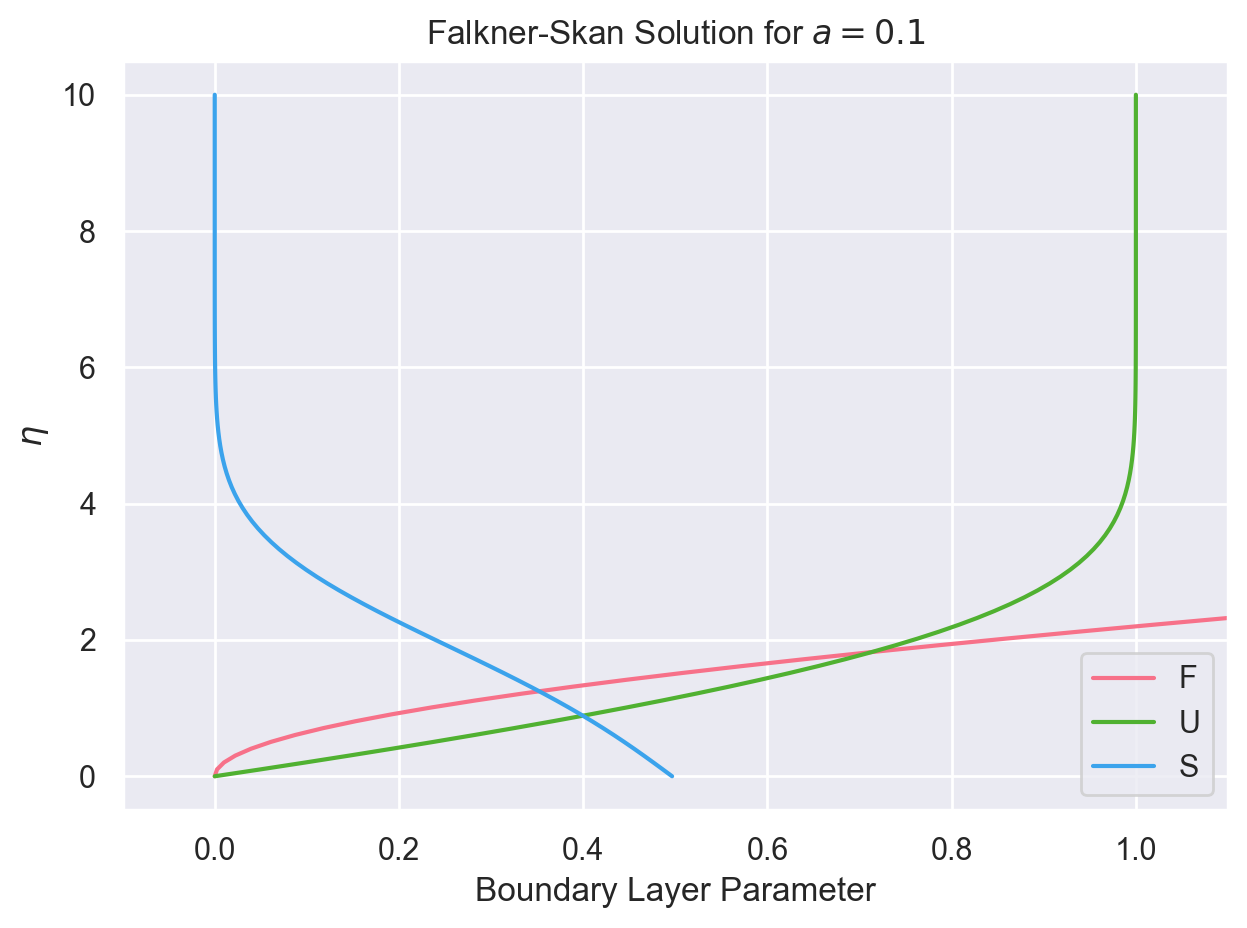

In [45]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(palette=sns.color_palette("husl", 3))

fig, ax = plt.subplots(1, 1, figsize=(6.4, 4.8), dpi=200)
for var in ["F", "U", "S"]:
    plt.plot(
        sol.value(eval(var)),
        eta,
        label=var
    )
plt.xlim(-0.1, 1.1)
plt.xlabel(r"Boundary Layer Parameter")
plt.ylabel(r"$\eta$")
plt.title(rf"Falkner-Skan Solution for $a = {sol.value(a)}$")
plt.tight_layout()
plt.legend()
plt.show()

Nice!

## Plotting Families of the ODE

For kicks, we can also plot $U(\eta)$ for a bunch of different values of $a$:

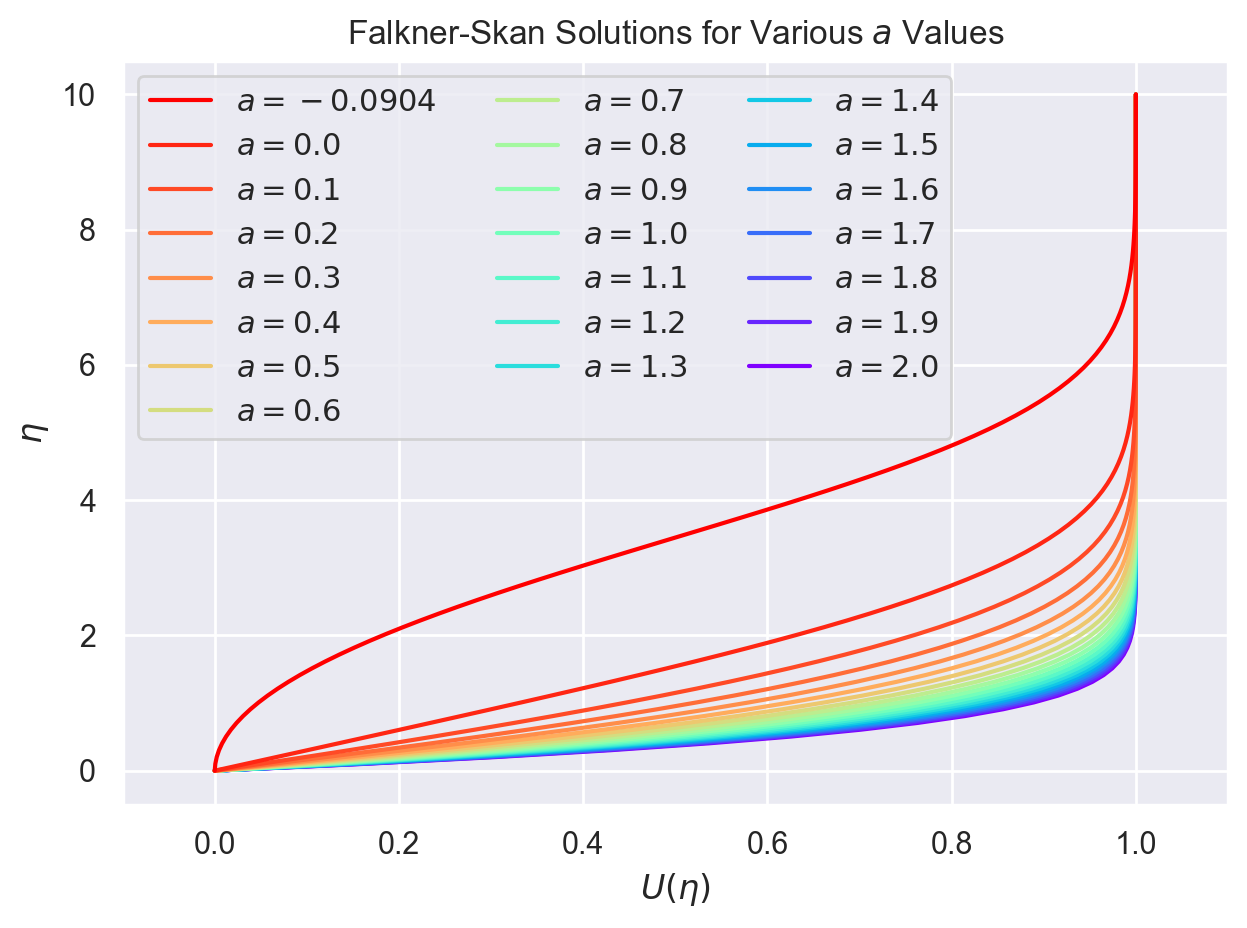

In [46]:
a_values = [-0.09044] + list(np.arange(0, 2.1, 0.1))

fig, ax = plt.subplots(1, 1, figsize=(6.4, 4.8), dpi=200)
colors = plt.cm.rainbow(np.linspace(1, 0, len(a_values)))

for i, value in enumerate(a_values):
    opti.set_value(a, value)
    sol = opti.solve(verbose=False)

    plt.plot(
        sol.value(U),
        eta,
        label=rf"$a = {sol.value(a):.1f}$" if i != 0 else rf"$a = {sol.value(a):.4f}$",
        color=colors[i],
        zorder=3 + len(a_values) - i
    )

plt.xlim(-0.1, 1.1)
plt.xlabel(r"$U(\eta)$")
plt.ylabel(r"$\eta$")
plt.title(r"Falkner-Skan Solutions for Various $a$ Values")
plt.tight_layout()
plt.legend(ncol=3)
plt.show()

Cool. So far, this has all been pretty normal. But, let's change it up a bit.

## Doing Inverse Analysis

Take a look at our solution above for $a \approx -0.0904$. Something interesting is happening here - this is an incipient separation flow. We can tell because the nondimensional shear $S(\eta) = dU/d\eta$ at the wall ($\eta = 0$) is going to zero.

But our value of $-0.0904$ was just a guess, found by trial and error. Suppose now we want to ask the following question: at what exact value of $a$ does the flow separate, as indicated by the wall shear $S(0)$ going exactly to zero?

If we had solved this ODE with traditional methods, this would be a big pain - we would need to add $a$ as an unknown and define another residual equation after differentiating with respect to $a$ before resolving.

One might suggest trial and error instead - why not guess a series of values of $a$ and pick the best one, or do something clever by post-processing the solve? The problem is that for $a < -0.0904$ no solution exists, so trial and error is really tedious and difficult. This is common - often the forward problem is well-posed but the inverse problem is not. So, we need to get a bit clever:

Here, we can solve the inverse problem super easily just by changing $a$ from a parameter to a variable and adding "zero wall shear" as an additional constraint:

In [47]:
opti = asb.Opti()  # Initialize an optimization/analysis environment

a = opti.variable(init_guess=0) # `a` is a variable now, initialized to a guess of 0 (the Blasius solution)

eta = np.linspace(0, 10, n_points)  # Discretize eta from 0 to 10.

F = opti.variable(  # Create a variable F that represents some function F(eta)
    init_guess=eta + 10 / 3 * (1 - eta / 10) ** 3
)
U = opti.derivative_of(  # Create a variable U that represents a derivative of F(eta) with respect to eta.
    variable=F,
    with_respect_to=eta,
    derivative_init_guess=1 - (1 - eta / 10) ** 2
)
S = opti.derivative_of(  # Create a variable S that represents a derviative of U(eta) with respect to eta.
    variable=U,
    with_respect_to=eta,
    derivative_init_guess=0.2 * (1 - eta / 10)
)

opti.constrain_derivative(
    variable=S,
    with_respect_to=eta,
    derivative=-(1 + a) / 2 * F * S - a * (1 - U ** 2)
)
opti.subject_to([
    F[0] == 0,
    U[0] == 0,
    U[-1] == 1,
    S[0] == 0, # We simply constrain the wall shear to be exactly 0.
])

[MX(fabs(opti10_lam_g_4)),
 MX(fabs(opti10_lam_g_5)),
 MX(fabs(opti10_lam_g_6)),
 MX(fabs(opti10_lam_g_7))]

Then, we solve again and print our answer for $a$:

In [48]:
sol = opti.solve(verbose=False)

print(f"Value of `a` at incipient separation: {sol.value(a)}")

Value of `a` at incipient separation: -0.0904433068306291


So, we can get the value of $a$ at incipient separation without any kind of manual fussing with residual Jacobians - it's all abstracted for us.

This type of solve is called the *inverse solution*, and it comes up **all the time** in engineering.

Another example of the inverse problem: we might analyze an airfoil at an angle of attack of 5 degrees and find that it has a lift coefficient of 0.6. Suppose then that we want to find the angle of attack that corresponds to a lift coefficient of 0.5 - in essense, *go backwards* from lift coefficient to angle of attack.

Solving the inverse problem is quite tedious without the abstracted approach used here, but it's easily implemented in AeroSandbox.